In [16]:
import os
import re
import spacy
import pydotplus
import numpy as np
import pandas as pd
from tqdm import tqdm
from functions import *
from sklearn.svm import SVC
from sklearn import preprocessing
from IPython.display import Image
from sklearn.metrics import f1_score
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [2]:
nlp = spacy.load("en")
path = './documents'
filenames = os.listdir(path)

In [3]:
nlp.vocab["cannot"].is_stop = False
nlp.vocab["give"].is_stop = False
nlp.vocab["never"].is_stop = False
nlp.vocab["nothing"].is_stop = False
nlp.vocab["third"].is_stop = False
nlp.vocab["without"].is_stop = False
nlp.vocab["neither"].is_stop = False
nlp.vocab["do"].is_stop = False
nlp.vocab["not"].is_stop = False

In [4]:
data = pd.DataFrame(columns=["id", "text"])

for index in tqdm(range(len(filenames))):
    filename = filenames[index]
    document = open(path+"/"+filename, encoding='utf-8', errors='ignore').read()
    data.loc[index] = [int(re.findall('\d+', filename)[0]), document]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:01<00:00, 263.28it/s]


In [5]:
data.drop_duplicates(subset=["text"], inplace=True)
data.reset_index(inplace=True, drop=True)

In [6]:
replacements = {' .':'.', " 's":"", '(s)':'', '(s':'', '   ':' '}
preprocessed_data = pd.DataFrame(columns=["id", "processed_text"])

for index in tqdm(range(len(data))):
    document = nlp(data.loc[index,"text"])
    filtered_sentence = [word for word in document if word.text in {'.', '?'} or word.is_stop is False and word.is_punct == False]
    filtered_sentence = ' '.join(map(str, filtered_sentence))
    filtered_sentence = multi_replace(filtered_sentence, replacements)
    filtered_sentence = str(filtered_sentence).lower()
    preprocessed_data.loc[index] = [data.loc[index,"id"], filtered_sentence]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [07:19<00:00,  2.03it/s]


In [9]:
preprocessed_data.to_csv("preprocessed_data_dropped_limited_features.csv", encoding='utf-8', index = False)

In [13]:
for index in tqdm(range(len(preprocessed_data))):
    text = preprocessed_data.loc[index, 'processed_text']
    preprocessed_data.loc[index, 'word_count'] = word_count(text)
    preprocessed_data.loc[index, 'sentence_count'] = sentence_count(text)
    preprocessed_data.loc[index, 'avg_sentence_length'] = preprocessed_data.loc[index, 'word_count'].astype('float')/preprocessed_data.loc[index, 'sentence_count'].astype('float')
    preprocessed_data.loc[index, 'syllables_count'] = syllables_count(text)
    preprocessed_data.loc[index, 'avg_syllables_per_word'] = avg_syllables_per_word(text)
    preprocessed_data.loc[index, 'difficult_words'] = difficult_words(text)
    preprocessed_data.loc[index, 'poly_syllable_count'] = poly_syllable_count(text)
    preprocessed_data.loc[index, 'flesch_reading_ease'] = flesch_reading_ease(text)
    preprocessed_data.loc[index, 'gunning_fog'] = gunning_fog(text)
    preprocessed_data.loc[index, 'smog_index'] = smog_index(text)
    preprocessed_data.loc[index, 'dale_chall_readability_score'] = dale_chall_readability_score(text)
    preprocessed_data.loc[index, 'is_email_addresses'] = is_email_addresses(text)
    preprocessed_data.loc[index, 'use_cookies'] = use_cookies(text)
    preprocessed_data.loc[index, 'is_minor'] = is_minor(text)
    preprocessed_data.loc[index, 'is_sell'] = is_sell(text)
    preprocessed_data.loc[index, 'not_sell'] = not_sell(text)
    preprocessed_data.loc[index, 'is_share'] = is_share(text)
    preprocessed_data.loc[index, 'not_share'] = not_share(text)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [3:13:37<00:00, 26.43s/it]


In [14]:
preprocessed_data.to_csv("processed_data_dropped_all_features.csv", encoding='utf-8', index = False)

In [18]:
y = pd.read_csv("training_labels.csv")
preprocessed_data["id"] = preprocessed_data["id"].astype("uint32")
preprocessed_data = pd.merge(preprocessed_data, y, on="id")
y = preprocessed_data.loc[:,'score']
del preprocessed_data['score']

In [19]:
columns_list = preprocessed_data.columns

In [20]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(preprocessed_data, y)
X_res = pd.DataFrame(X_res, columns = columns_list)
y_res = pd.DataFrame(y_res, columns=['score'])

In [21]:
X_res.to_csv("processed_data_oversampled_all_features.csv", encoding='utf-8', index = False)

In [22]:
features = ['word_count', 'sentence_count', 'syllables_count', 'difficult_words', 'poly_syllable_count', 'flesch_reading_ease',
       'gunning_fog', 'smog_index', 'dale_chall_readability_score', 'is_email_addresses', 'use_cookies', 'is_minor', 'is_sell', 
        'not_sell', 'is_share', 'not_share']

In [23]:
geolocation_synonyms = set(['geo-location', 'geolocation', 'location', 'position'])
vendor_synonyms = set(['vendor', 'vender', 'seller', 'marketer'])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_res[features], y_res, test_size=0.33, random_state=42)

In [25]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, np.ravel(y_train))
pred = model.predict(X_test)

In [26]:
precision_recall_fscore_support(y_test, pred, average='weighted')

(0.8388086004985694, 0.8444444444444444, 0.8356730297807249, None)

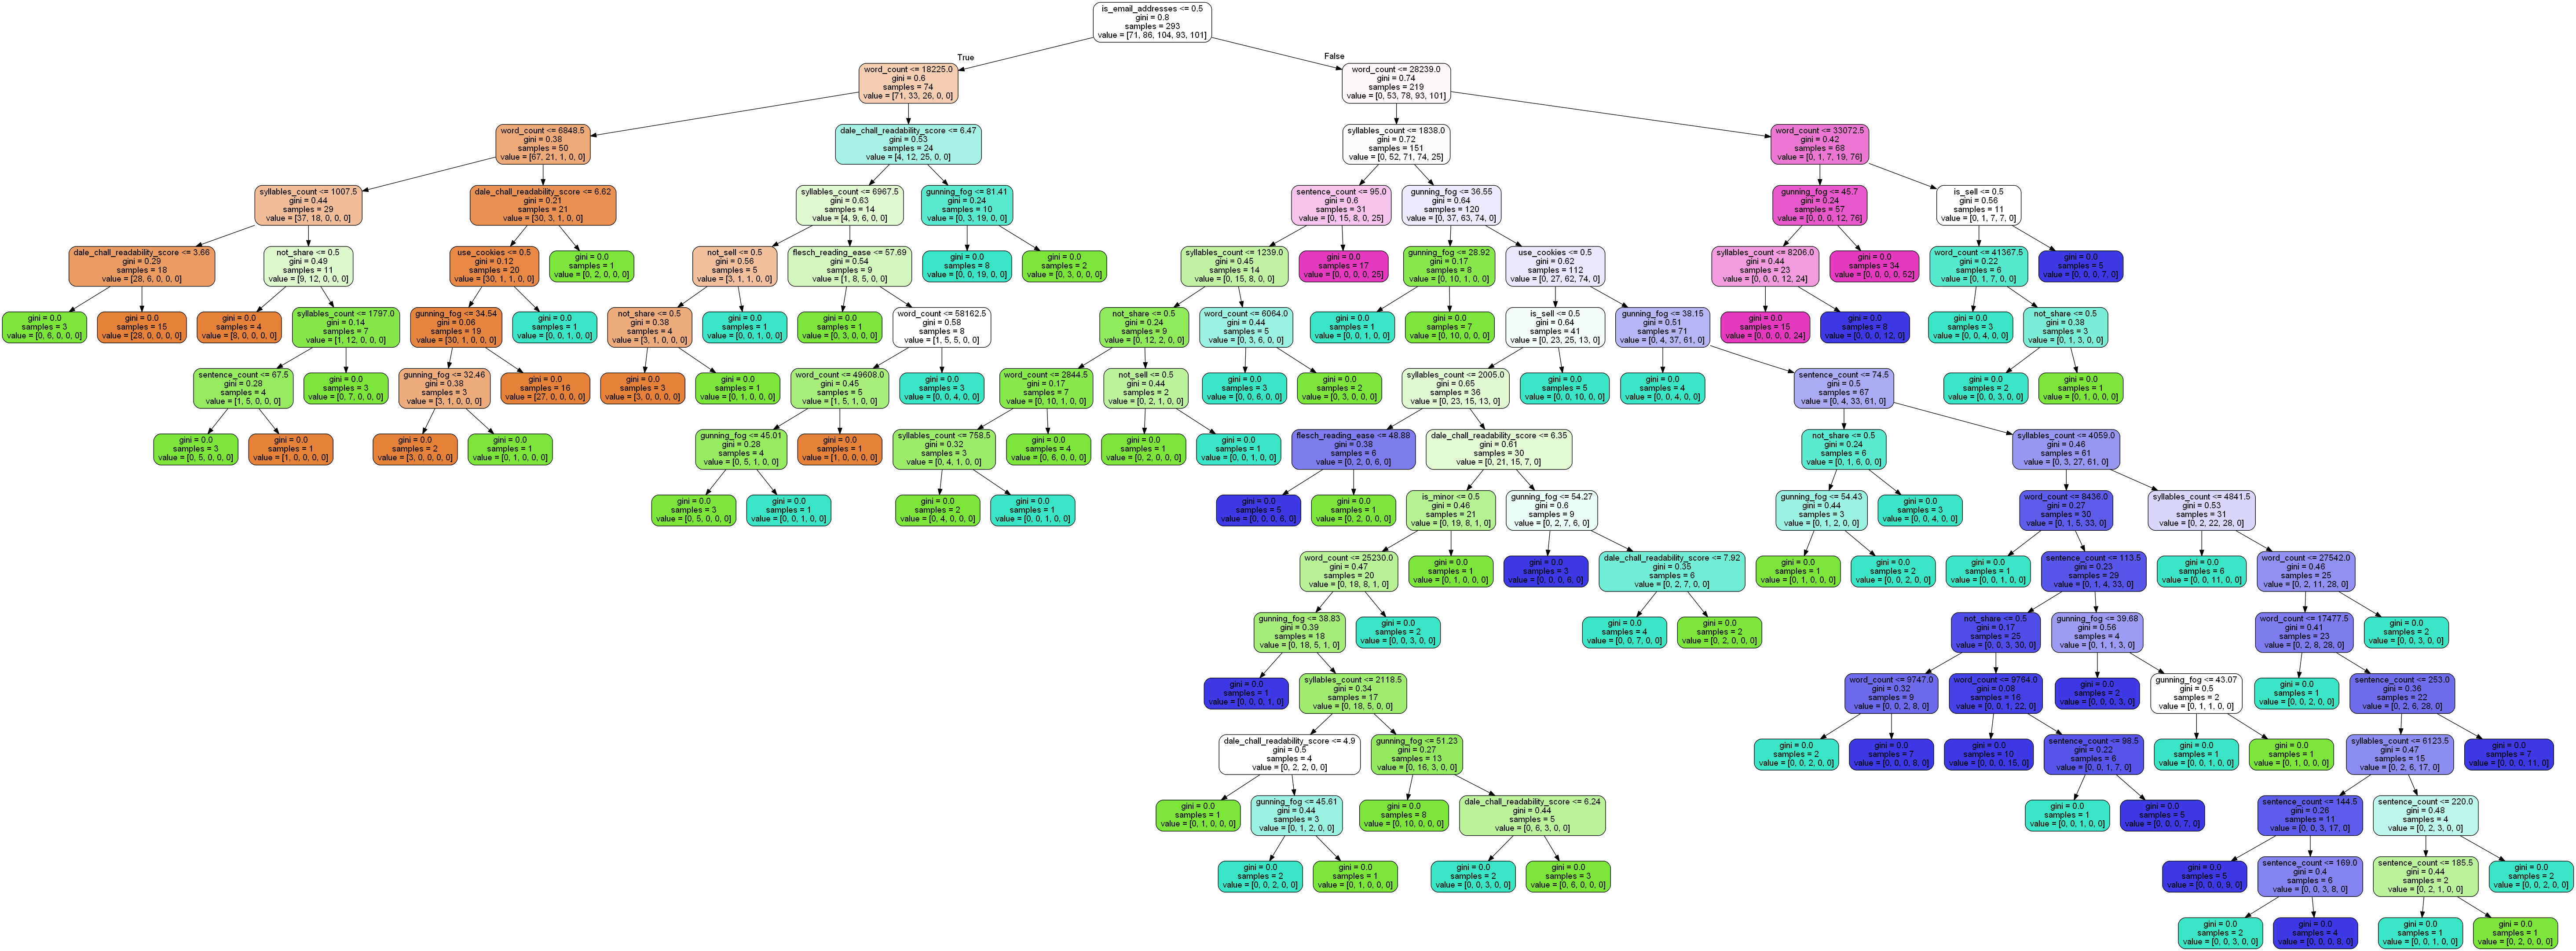

In [27]:
estimator = model.estimators_[10]

from sklearn.tree import export_graphviz
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features,
                class_names = None,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

graph = pydotplus.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


Image(filename = 'tree.png')

In [8]:
import pandas as pd
data=pd.read_csv('processed_data_dropped_all_features.csv',encoding='utf-8')
from functions import *

In [2]:
data

,id,processed_text,word_count,sentence_count,avg_sentence_length,syllables_count,avg_syllables_per_word,difficult_words,poly_syllable_count,flesch_reading_ease,gunning_fog,smog_index,dale_chall_readability_score,is_email_addresses,use_cookies,is_minor,is_sell,not_sell,is_share,not_share
0,10051,gdpr privacy notice \r\n introduction at nova ...,21453.0,140.0,153.235714,6095.0,0.3,1.0,0.0,25.92,63.296150,3.1,7.60,1.0,1.0,0.0,0.0,0.0,1.0,1.0
1,10062,at&t business customer gdpr privacy notice may...,10972.0,95.0,115.494737,3176.0,0.3,1.0,0.0,64.23,48.201540,3.1,5.73,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10065,wesley house data protection statement privacy...,8062.0,88.0,91.613636,2271.0,0.3,1.0,0.0,88.47,38.650416,3.1,4.55,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,10077,privacy notices \r\n an explanation privacy no...,22904.0,158.0,144.962025,6431.0,0.3,1.0,0.0,34.32,59.986557,3.1,7.19,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,10080,privacy notice for visitors and contractors \r...,6292.0,65.0,96.800000,1779.0,0.3,1.0,0.0,83.20,40.726357,3.1,4.80,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,10170,general data protection regulation gdpr \r\n p...,7181.0,74.0,97.040541,2086.0,0.3,1.0,0.0,82.96,40.821786,3.1,4.82,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,10173,office product safety standards privacy notice...,8912.0,69.0,129.159420,2550.0,0.3,1.0,0.0,50.36,53.668256,3.1,6.41,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7,10176,personal data processing by goldman sachs fair...,18401.0,115.0,160.008696,5185.0,0.3,1.0,0.0,19.05,66.005652,3.1,7.94,1.0,0.0,1.0,0.0,0.0,1.0,1.0
8,10179,preparing general data protection regulation \...,70852.0,645.0,109.848062,20482.0,0.3,1.0,0.0,69.96,45.939789,3.1,5.45,1.0,1.0,0.0,0.0,0.0,1.0,0.0
9,10183,the gdpr you \r\n general data protection regu...,14271.0,177.0,80.627119,4157.0,0.3,1.0,0.0,99.62,34.253650,3.1,4.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
data['vendor']=data['processed_text'].apply(lambda x: vendor(x))

In [10]:
data[data.is_share==1]

,id,processed_text,word_count,sentence_count,avg_sentence_length,syllables_count,avg_syllables_per_word,difficult_words,poly_syllable_count,flesch_reading_ease,...,smog_index,dale_chall_readability_score,is_email_addresses,use_cookies,is_minor,is_sell,not_sell,is_share,not_share,vendor
0,10051,gdpr privacy notice \r\n introduction at nova ...,21453.0,140.0,153.235714,6095.0,0.3,1.0,0.0,25.92,...,3.1,7.60,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1
1,10062,at&t business customer gdpr privacy notice may...,10972.0,95.0,115.494737,3176.0,0.3,1.0,0.0,64.23,...,3.1,5.73,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,10065,wesley house data protection statement privacy...,8062.0,88.0,91.613636,2271.0,0.3,1.0,0.0,88.47,...,3.1,4.55,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0
3,10077,privacy notices \r\n an explanation privacy no...,22904.0,158.0,144.962025,6431.0,0.3,1.0,0.0,34.32,...,3.1,7.19,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0
4,10080,privacy notice for visitors and contractors \r...,6292.0,65.0,96.800000,1779.0,0.3,1.0,0.0,83.20,...,3.1,4.80,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
5,10170,general data protection regulation gdpr \r\n p...,7181.0,74.0,97.040541,2086.0,0.3,1.0,0.0,82.96,...,3.1,4.82,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
6,10173,office product safety standards privacy notice...,8912.0,69.0,129.159420,2550.0,0.3,1.0,0.0,50.36,...,3.1,6.41,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0
7,10176,personal data processing by goldman sachs fair...,18401.0,115.0,160.008696,5185.0,0.3,1.0,0.0,19.05,...,3.1,7.94,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0
8,10179,preparing general data protection regulation \...,70852.0,645.0,109.848062,20482.0,0.3,1.0,0.0,69.96,...,3.1,5.45,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1
9,10183,the gdpr you \r\n general data protection regu...,14271.0,177.0,80.627119,4157.0,0.3,1.0,0.0,99.62,...,3.1,4.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
